# Gourmet Meals Business -- SQL Project (Part 1.5 - Data Visualization)

Author: **Ethan Moody**

Date: **September 2022**

### Business Case

A few years ago, a new startup was born: **Agile Gourmet Meals (AGM)**.

The founder of AGM was a sous chef in a 5-star restaurant, named Joy, who had worked her way up from dishwasher to cook to sous chef. As part of her job, Joy frequently shopped at the high end grocery stores that featured organic and healthier selections for their food, at premium prices, as the 5-star restaurant wanted only the highest quality ingredients for their food. Also, part of her job was to be paid to eat meals on her time off at other restaurants from fast food to other 5-star to see what types of food and quality were being served.

Joy noticed that most young, single professionals tended to:
* Eat out frequently, with a mix of mostly casual dining, with some fast food, and occasional 5-star restaurants
* Order delivery at home or work
* Take out for home or work
* Buy frozen pre-made meals and microwave them at home

Joy also noticed that all of these options were typically not very healthy.

Joy had an idea to create a new business. She would cook healthy, gourmet quality meals and fix them in containers similar to the frozen pre-made meals purchased in grocery stores, except they would be fresh (not frozen) to improve the taste. She would seek to market them at a local high end grocery store.

Joy struck a deal with the high end grocery store to setup a small counter there near the entry way. At the counter she would educate the customers about her meals, take orders, and deliver them. As the business grew, Joy rented space near the store and setup her kitchen there, hiring someone else to staff the counter at the grocery store. Joy also hired a web developer to develop a website to take orders, handle payments, etc.

After a couple years, the grocery store's corporate office was so pleased with the arrangement, they asked AGM to expand to several other cities. They selected stores in the areas of town with more young professionals, and/or areas known for more affluence. They provided funding for a joint venture to allow AGM to setup kitchens near the store and enhance the web and phone app ordering system. In exchange for their investment, they received controlling interest in the business. Joy stayed on, where she would continue to act as an expert on the food side of the business.

AGM has just finished a very successful year on the enhanced computer systems, and now has a database of sales data for one year.

AGM charges a flat rate of $12 per meal with no minimum. Since the food has to be heated before eating, it is not subject to sales tax. Customers must order by 10am one day in order to pick up the meals the next day. The thinking is that AGM will waste much less food that way. Customers will have a maximum of one order per day.

AGM is in the process of creating a data science team and a data engineering team. You have just been hired as the first data engineer for the data engineering team. You met with the data science team and they explained to you the story above, and more importantly, that they now have a database of sales data for one year (2020).  

Together with the data science team, you worked out a list of high priority data engineering tasks that need to be done. The data science team has been working with the business side to come up with some business questions that will need some queries written against the sales database to help them answer:
* Sales Related Queries
* Customer Related Queries
* Meal Related Queries
* A Holiday Related Query

The data science team would like to see an example of a data visualization using Python from data in a Pandas dataframe containing data from an SQL query. They are familiar with other data visualization tools, but not with using Python, and they want to see a good example.

The data science team is building a model to help identify the company's best customers. They are starting with the very common RFM model. Since you will be the one looking at the database in the most detail, they would like for you to write up your best ideas on how the sales data can be used for this model.

# Included Modules and Packages

In [1]:
import math
import numpy as np
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sns

# Additional Setup Code

In [2]:
# Function to run a select query and return rows in a pandas dataframe
# Note: pandas formats all numeric values from postgres as float

def my_select_query_pandas(query, rollback_before_flag, rollback_after_flag):
    "Function to run a select query and return rows in a pandas dataframe"
    
    if rollback_before_flag:
        connection.rollback()
    
    df = pd.read_sql_query(query, connection)
    
    if rollback_after_flag:
        connection.rollback()
    
    # Fix any float columns that really should be integers
    
    for column in df:
    
        if df[column].dtype == "float64":

            fraction_flag = False

            for value in df[column].values:
                
                if not np.isnan(value):
                    if value - math.floor(value) != 0:
                        fraction_flag = True

            if not fraction_flag:
                df[column] = df[column].astype('Int64')
    
    return(df)

In [3]:
# Set up connection to postgres
# Note: All connection inputs below have been removed for protection
connection = psycopg2.connect(
    user = "",
    password = "",
    host = "",
    port = "",
    database = ""
)

# 1.5 Example of a Data Visualization created using Python

In [4]:
# Query returns market penetration rates and avg. dollar amount of revenue per customer by store location

rollback_before_flag = True
rollback_after_flag = True

query = """

with
  
  custpop as
  (
  select
    tsub_custpopbyzip.store_name
  , sum(tsub_custpopbyzip.unique_customers) as total_unique_customers
  , sum(tsub_custpopbyzip.population) as total_population
  , round((sum(tsub_custpopbyzip.unique_customers)/sum(tsub_custpopbyzip.population))*100,3) as market_penetration

  from
    (
    select
      t1_stores.city as store_name
    , t1_stores.zip as store_zip
    , count(distinct(t2_customers.customer_id)) as unique_customers
    , t3_zipcodes.population as population

    from stores as t1_stores

    join customers as t2_customers
    on t1_stores.store_id = t2_customers.closest_store_id
  
    join zip_codes as t3_zipcodes
    on t2_customers.zip = t3_zipcodes.zip

    group by
      t1_stores.city
    , t1_stores.zip
    , t3_zipcodes.population
    ) as tsub_custpopbyzip

  group by
    tsub_custpopbyzip.store_name

  order by
    tsub_custpopbyzip.store_name
  ),
  
  custsales as
  (
  select
    t1_stores.city as store_name
  , sum(t2_sales.total_amount) as total_sales_dollars
  , count(t2_sales.sale_id) as total_number_of_sales
  , round(sum(t2_sales.total_amount)/count(t2_sales.sale_id),2) as average_dollar_amount_per_sale

  from stores as t1_stores

  join sales as t2_sales
  on t1_stores.store_id = t2_sales.store_id

  group by
    t1_stores.city

  order by
    t1_stores.city
  )

select
  custpop.store_name as store_name
, custpop.total_unique_customers as total_unique_customers
, custpop.total_population as total_population
, custpop.market_penetration as market_penetration
, custsales.total_sales_dollars as total_sales_dollars
, custsales.total_number_of_sales as total_number_of_sales
, custsales.average_dollar_amount_per_sale as average_dollar_amount_per_sale
, round(custsales.total_number_of_sales/custpop.total_unique_customers,2) as average_number_of_sales_per_customer
, round(custsales.total_sales_dollars/custpop.total_unique_customers,2) as average_revenue_per_customer

from custpop

join custsales
on custpop.store_name = custsales.store_name

group by
  custpop.store_name
, custpop.total_unique_customers
, custpop.total_population
, custpop.market_penetration
, custsales.total_sales_dollars
, custsales.total_number_of_sales
, custsales.average_dollar_amount_per_sale

order by
  custpop.store_name

;

"""

df = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
df

,store_name,total_unique_customers,total_population,market_penetration,total_sales_dollars,total_number_of_sales,average_dollar_amount_per_sale,average_number_of_sales_per_customer,average_revenue_per_customer
0,Berkeley,8138,4085259,0.199,25041060,390375,64.15,47.97,3077.05
1,Dallas,6359,4843027,0.131,19408260,302120,64.24,47.51,3052.09
2,Miami,5725,3494568,0.164,17692404,275074,64.32,48.05,3090.38
3,Nashville,3646,1312968,0.278,14573172,227721,64.00,62.46,3997.03
4,Seattle,7214,2952746,0.244,22024512,342327,64.34,47.45,3053.02


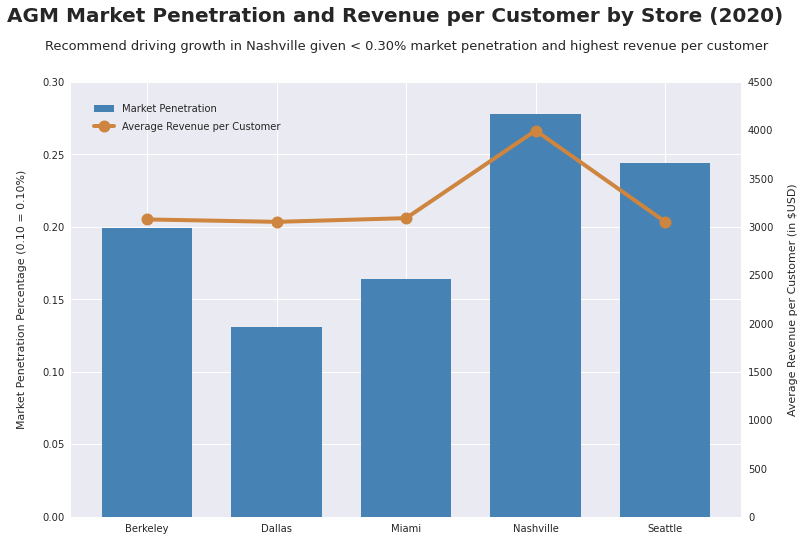

In [5]:
# Create visualization

# Set %matplotlib inline to display plots directly below code in notebook
%matplotlib inline

# Set plot style to preferred style
plt.style.use("seaborn")

# Create figure and first 'axis'
fig, ax1 = plt.subplots(figsize = (12, 8))

# Add chart title and sub-title
fig.suptitle(
    "AGM Market Penetration and Revenue per Customer by Store (2020)",
    x = 0.50,
    y = 1.01,
    ha = "center",
    fontsize = 20,
    fontweight = "bold")
ax1.set_title(
    "Recommend driving growth in Nashville given < 0.30% market penetration and highest revenue per customer",
    x = 0.50,
    y = 1.06,
    ha = "center",
    fontsize = 13)

# Add bar chart on first 'axis'
ax1.bar(
    df["store_name"],
    df["market_penetration"],
    width = 0.7,
    color = "steelblue")
ax1.set_ylabel(
    "Market Penetration Percentage (0.10 = 0.10%)",
    labelpad = 15)
ax1.set_ylim(0, 0.3)
ax1.legend(
    ["Market Penetration"],
    frameon = False,
    bbox_to_anchor = (0.02, 0.97),
    loc = "upper left")

# Create second 'axis' with same x-axis values as first 'axis'
ax2 = ax1.twinx()

# Add line chart on second 'axis'
ax2.plot(
    df["store_name"],
    df["average_revenue_per_customer"],
    linewidth = 4,
    marker = "o",
    markersize = 12,
    color = "peru") 
ax2.grid(False)
ax2.set_ylabel(
    "Average Revenue per Customer (in $USD)",
    labelpad = 15)
ax2.set_ylim(0, 4500)
ax2.legend(
    ["Average Revenue per Customer"],
    frameon = False,
    bbox_to_anchor = (0.02, 0.93),
    loc = "upper left")

# Display visualization
plt.show()

# =========================================================
# NOTE: The next cells contain supplementary code/visuals
# =========================================================

In [6]:
# ===================================================================================================================
# SUPPLEMENTAL SQL CODE, NOT DISPLAYED - TOTAL REVENUE (SALES) PER CUSTOMER BY STORE = 'BERKELEY'
# ===================================================================================================================

# Query returns dollar amount of revenue per customer by store location = 'Berkeley'

# rollback_before_flag = True
# rollback_after_flag = True

# query = """

# select distinct
#   t1_stores.city as store_name
# , t2_sales.customer_id as customer_id
# , sum(t2_sales.total_amount) as total_sales_dollars

# from stores as t1_stores

# join sales as t2_sales
# on t1_stores.store_id = t2_sales.store_id

# where
#   t1_stores.city = 'Berkeley'

# group by
#   t1_stores.city
# , t2_sales.customer_id

# order by
#   total_sales_dollars

# ;

# """

# dfb = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
# dfb

In [7]:
# ===================================================================================================================
# SUPPLEMENTAL VISUALIZATION, NOT DISPLAYED - HISTOGRAM OF REVENUE (SALES) PER CUSTOMER BY STORE = 'BERKELEY'
# ===================================================================================================================

# Create visualization to look at distribution and check for any outliers/abnormalities that could skew the average

# dfb.hist(column = 'total_sales_dollars')

In [8]:
# ===================================================================================================================
# SUPPLEMENTAL SQL CODE, NOT DISPLAYED - TOTAL REVENUE (SALES) PER CUSTOMER BY STORE = 'DALLAS'
# ===================================================================================================================

# Query returns dollar amount of revenue per customer by store location = 'Dallas'

# rollback_before_flag = True
# rollback_after_flag = True

# query = """

# select distinct
#   t1_stores.city as store_name
# , t2_sales.customer_id as customer_id
# , sum(t2_sales.total_amount) as total_sales_dollars

# from stores as t1_stores

# join sales as t2_sales
# on t1_stores.store_id = t2_sales.store_id

# where
#   t1_stores.city = 'Dallas'

# group by
#   t1_stores.city
# , t2_sales.customer_id

# order by
#   total_sales_dollars

# ;

# """

# dfd = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
# dfd

In [9]:
# ===================================================================================================================
# SUPPLEMENTAL VISUALIZATION, NOT DISPLAYED - HISTOGRAM OF REVENUE (SALES) PER CUSTOMER BY STORE = 'DALLAS'
# ===================================================================================================================

# Create visualization to look at distribution and check for any outliers/abnormalities that could skew the average

# dfd.hist(column = 'total_sales_dollars')

In [10]:
# ===================================================================================================================
# SUPPLEMENTAL SQL CODE, NOT DISPLAYED - TOTAL REVENUE (SALES) PER CUSTOMER BY STORE = 'MIAMI'
# ===================================================================================================================

# Query returns dollar amount of revenue per customer by store location = 'Miami'

# rollback_before_flag = True
# rollback_after_flag = True

# query = """

# select distinct
#   t1_stores.city as store_name
# , t2_sales.customer_id as customer_id
# , sum(t2_sales.total_amount) as total_sales_dollars

# from stores as t1_stores

# join sales as t2_sales
# on t1_stores.store_id = t2_sales.store_id

# where
#   t1_stores.city = 'Miami'

# group by
#   t1_stores.city
# , t2_sales.customer_id

# order by
#   total_sales_dollars

# ;

# """

# dfm = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
# dfm

In [11]:
# ===================================================================================================================
# SUPPLEMENTAL VISUALIZATION, NOT DISPLAYED - HISTOGRAM OF REVENUE (SALES) PER CUSTOMER BY STORE = 'MIAMI'
# ===================================================================================================================

# Create visualization to look at distribution and check for any outliers/abnormalities that could skew the average

# dfm.hist(column = 'total_sales_dollars')

In [12]:
# ===================================================================================================================
# SUPPLEMENTAL SQL CODE, NOT DISPLAYED - TOTAL REVENUE (SALES) PER CUSTOMER BY STORE = 'NASHVILLE'
# ===================================================================================================================

# Query returns dollar amount of revenue per customer by store location = 'Nashville'

# rollback_before_flag = True
# rollback_after_flag = True

# query = """

# select distinct
#   t1_stores.city as store_name
# , t2_sales.customer_id as customer_id
# , sum(t2_sales.total_amount) as total_sales_dollars

# from stores as t1_stores

# join sales as t2_sales
# on t1_stores.store_id = t2_sales.store_id

# where
#   t1_stores.city = 'Nashville'

# group by
#   t1_stores.city
# , t2_sales.customer_id

# order by
#   total_sales_dollars

# ;

# """

# dfn = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
# dfn

In [13]:
# ===================================================================================================================
# SUPPLEMENTAL VISUALIZATION, NOT DISPLAYED - HISTOGRAM OF REVENUE (SALES) PER CUSTOMER BY STORE = 'NASHVILLE'
# ===================================================================================================================

# Create visualization to look at distribution and check for any outliers/abnormalities that could skew the average

# dfn.hist(column = 'total_sales_dollars')

In [14]:
# ===================================================================================================================
# SUPPLEMENTAL SQL CODE, NOT DISPLAYED - TOTAL REVENUE (SALES) PER CUSTOMER BY STORE = 'SEATTLE'
# ===================================================================================================================

# Query returns dollar amount of revenue per customer by store location = 'Seattle'

# rollback_before_flag = True
# rollback_after_flag = True

# query = """

# select distinct
#   t1_stores.city as store_name
# , t2_sales.customer_id as customer_id
# , sum(t2_sales.total_amount) as total_sales_dollars

# from stores as t1_stores

# join sales as t2_sales
# on t1_stores.store_id = t2_sales.store_id

# where
#   t1_stores.city = 'Seattle'

# group by
#   t1_stores.city
# , t2_sales.customer_id

# order by
#   total_sales_dollars

# ;

# """

# dfs = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
# dfs

In [15]:
# ===================================================================================================================
# SUPPLEMENTAL VISUALIZATION, NOT DISPLAYED - HISTOGRAM OF REVENUE (SALES) PER CUSTOMER BY STORE = 'SEATTLE'
# ===================================================================================================================

# Create visualization to look at distribution and check for any outliers/abnormalities that could skew the average

# dfs.hist(column = 'total_sales_dollars')